# Разработка нейросетевого алгоритма для решения задачи MNIST

In [ ]:
# Импорт библиотек
import numpy as np
import math
from sklearn.model_selection import train_test_split

import mnist
import torch

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Загрузка датасета MNIST

## Нормализация изображений и добавление дополнительного измерения (канала). Так, нейросеть сможет работать с изображениями, имеющими более одного цветового канала.

In [ ]:
train_images = torch.from_numpy(mnist.train_images())[:, np.newaxis, :, :].float() / 255.
train_labels = torch.from_numpy(mnist.train_labels()).long()

test_images = torch.from_numpy(mnist.test_images())[:, np.newaxis, :, :].float() / 255.
test_labels = torch.from_numpy(mnist.test_labels()).long()

## Визуализация нескольких изображений с метками класса

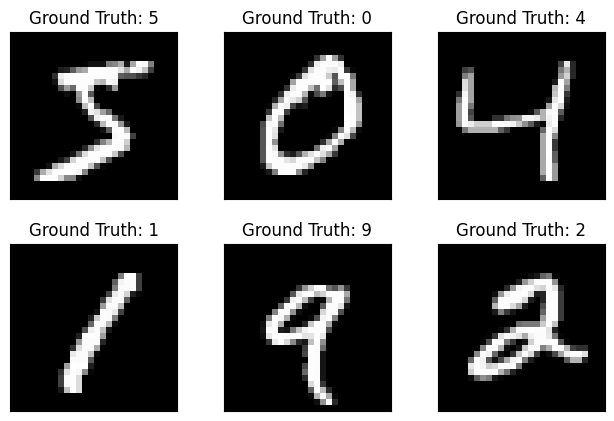

In [ ]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(train_images[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(train_labels[i]))
    plt.xticks([])
    plt.yticks([])

# Импорт библиотек из pytorch и реализация класса нейронной сети

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

## Класс EarlyStopping

### Этот класс реализует функционал ранней остаоновки. Так мы сможем избежать переобучения нейросети и остановить обучение раньше инициализированного количества эпох.

In [ ]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0.01):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, losses):
        if (losses[0] - losses[1])/losses[0] <= self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

### Класс нейронной сети. Данный класс является универсальным (относительно, т.к. для решение табличной задачи классификации необходимо задать подходящую функцию ошибки). Т.е. с помощью этого конструктора можно решать классические задачи регрессии и классификации, а также задачу классификации изображений. Способ задания нейросети интуитивно понятный: последовательно в виде словарей python задаются параметры очередного слоя нейронной сети. Таким образом, мы можем видеть архитектуру нейронной сети на этапе инициализации, а сам класс будет являться чем-то вроде черного ящика. Также добавлена возможность выбора различных оптимизаторов, функций потерь.

In [ ]:
class RegressionNet(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.previous_shape = args[0].shape if len(args[0].shape) == 3 else args[0][np.newaxis, :].shape
        self.layers = nn.ModuleList([self.choose_layer(**arg) for arg in args[1]])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def predict(self, X):
        return [x.argmax() for x in self.forward(X)]

    def train(self, X, y, optimizer='Adam', lr=0.01, epochs=1000, tolerance=5, min_delta=0.001, batch=None, val_part=0.1):

        self.optimizer = self.choose_optimizer(optimizer=optimizer, lr=lr)
        self.erls = EarlyStopping(tolerance=tolerance, min_delta=min_delta)
        self.loss = self.choose_loss(loss='CrossEntropy')
        self.train_epoch_losses = []
        self.val_epoch_losses = []
        self.batch = X.shape[0] if batch is None else batch

        X_train, X_val, y_train, y_val = None, None, None, None

        for epoch in range(epochs):

            X_train, X_val, y_train, y_val = None, None, None, None

            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_part, random_state=42)

            step = 0
            batch = 0

            for start_index in range(0, X_train.shape[0], self.batch):
                batch += 1
                step += 1

                self.optimizer.zero_grad()

                x_batch = X_train[start_index:start_index+self.batch]
                y_batch = y_train[start_index:start_index+self.batch]

                preds = self.forward(x_batch)

                loss_val = self.loss(preds, y_batch)
                loss_val.backward()

                self.optimizer.step()

            self.train_epoch_losses.append(self.loss(self.forward(X_train), y_train).item())
            self.val_epoch_losses.append(self.loss(self.forward(X_val), y_val).item())

            print(f'epoch {epoch + 1}/{epochs}: train_loss={self.train_epoch_losses[-1]}, val_loss={self.val_epoch_losses[-1]}')

            if len(self.val_epoch_losses) > 2:
                self.erls(self.val_epoch_losses[-2:])
                if self.erls.early_stop:
                    print(f'Early Stop at epoch {epoch + 1}')
                    break

        return 0


    def choose_layer(self, layer, in_features=None, out_features=None, dropout=None,
                     in_channels=None, out_channels=None, kernel=None, stride=None, padding=None):
        if layer == 'linear':
            assert (in_features is not None) and (out_features is not None) and (dropout is None) and \
            (in_channels is None) and (out_channels is None) and (kernel is None) and \
            (stride is None) and (padding is None)
            return nn.Linear(in_features=self.previous_shape if in_features == 'prev' else in_features,
                             out_features=out_features, bias=True)
        elif layer == 'flatten':
            assert (in_features is None) and (out_features is None) and (dropout is None) and \
            (in_channels is None) and (out_channels is None) and (kernel is None) and \
            (stride is None) and (padding is None)
            self.previous_shape = math.prod(self.previous_shape)
            return nn.Flatten()
        elif layer == 'softmax':
            assert (in_features is None) and (out_features is None) and (dropout is None) and \
            (in_channels is None) and (out_channels is None) and (kernel is None) and \
            (stride is None) and (padding is None)
            return nn.Softmax(dim=1)
        elif layer == 'tanh':
            assert (in_features is None) and (out_features is None) and (dropout is None) and \
            (in_channels is None) and (out_channels is None) and (kernel is None) and \
            (stride is None) and (padding is None)
            return nn.Tanh()
        elif layer == 'sigmoid':
            assert (in_features is None) and (out_features is None) and (dropout is None) and \
            (in_channels is None) and (out_channels is None) and (kernel is None) and \
            (stride is None) and (padding is None)
            return nn.Sigmoid()
        elif layer == 'dropout':
            assert (in_features is None) and (out_features is None) and (dropout is not None) and \
            (in_channels is None) and (out_channels is None) and (kernel is None) and \
            (stride is None) and (padding is None)
            return nn.Dropout(p=dropout)
        elif layer == 'conv2d':
            assert (in_features is None) and (out_features is None) and (dropout is None) and \
            (in_channels is not None) and (out_channels is not None) and (kernel is not None) and\
            (stride is not None) and (padding is not None)
            self.previous_shape = self.calc_out_shape_conv(self.previous_shape[1], self.previous_shape[2],
                                                 out_channels, kernel, stride, padding)
            return nn.Conv2d(in_channels, out_channels, kernel, stride=stride, padding=padding)
        elif layer == 'max_pooling':
            assert (in_features is None) and (out_features is None) and (dropout is None) and \
            (in_channels is None) and (out_channels is None) and (kernel is not None) and\
            (stride is not None) and (padding is not None)
            self.previous_shape = self.calc_out_shape_pool(self.previous_shape[1], self.previous_shape[2],
                                                 self.previous_shape[0], kernel, stride, padding)
            return nn.MaxPool2d(kernel, stride=stride, padding=padding)

    def calc_out_shape_conv(self, H_in, W_in, out_channels, kernel_size, stride, padding):
        H_out = ((H_in - kernel_size + 2 * padding) // stride) + 1
        W_out = ((W_in - kernel_size + 2 * padding) // stride) + 1
        out_shape = (out_channels, H_out, W_out)

        return out_shape

    def calc_out_shape_pool(self, H_in, W_in, out_channels, kernel_size, stride, padding):
        H_out = ((H_in + 2 * padding - kernel_size) // stride) + 1
        W_out = ((W_in + 2 * padding - kernel_size) // stride) + 1
        out_shape = (out_channels, H_out, W_out)

        return out_shape

    def choose_optimizer(self, optimizer='Adam', lr=0.01):
        if optimizer=='SGD':
            return torch.optim.SGD(self.parameters(), lr=lr)
        elif optimizer=='Adam':
            return torch.optim.Adam(self.parameters(), lr=lr)
        elif optimizer=='RMSprop':
            return torch.optim.RMSprop(self.parameters(), lr=lr)

    def choose_loss(self, loss='CrossEntropy'):
        if loss=='RMSE':
            def _rmse(pred, target):
                return torch.sqrt(((pred - target) ** 2).mean())
            return _rmse
        elif loss=='MSE':
            def _mse(pred, target):
                return ((pred - target) ** 2).mean()
            return _mse
        elif loss=='MAE':
            def _mae(pred, target):
                return torch.abs(pred - target).mean()
            return _mae
        elif loss=='CrossEntropy':
            return nn.CrossEntropyLoss()

# Инициализация нейронной сети. Методом научного тыка с первого раза удалось подобрать архитектуру нейронной сети, которая хорошо показывает себя на тестовых данных и имеет маленькую ошибку на валидационном наборе.

In [ ]:
neural_network = RegressionNet(train_images[0],
                               (dict(layer='conv2d', in_channels=1, out_channels=4, kernel=5, stride=1, padding=0),
                                dict(layer='max_pooling', kernel=5, stride=1, padding=0),
                                dict(layer='conv2d', in_channels=4, out_channels=2, kernel=5, stride=1, padding=0),
                                dict(layer='max_pooling', kernel=5, stride=1, padding=0),
                                dict(layer='flatten'),
                                dict(layer='linear', in_features='prev', out_features=100),
                                dict(layer='tanh'),
                                dict(layer='linear', in_features=100, out_features=10)))

## Обучение нейронной сети

In [ ]:
neural_network.train(train_images, train_labels, batch=10000)

epoch 1/1000: train_loss=2.130871057510376, val_loss=2.1389987468719482
epoch 2/1000: train_loss=1.4969282150268555, val_loss=1.5059728622436523
epoch 3/1000: train_loss=1.0156370401382446, val_loss=1.0189021825790405
epoch 4/1000: train_loss=0.7168490886688232, val_loss=0.7121822834014893
epoch 5/1000: train_loss=0.5531443357467651, val_loss=0.5462844371795654
epoch 6/1000: train_loss=0.44691234827041626, val_loss=0.4385410249233246
epoch 7/1000: train_loss=0.3881581723690033, val_loss=0.3798477053642273
epoch 8/1000: train_loss=0.3457536995410919, val_loss=0.33714842796325684
epoch 9/1000: train_loss=0.3144221901893616, val_loss=0.3050402104854584
epoch 10/1000: train_loss=0.28882595896720886, val_loss=0.2791405916213989
epoch 11/1000: train_loss=0.2657797634601593, val_loss=0.2587372064590454
epoch 12/1000: train_loss=0.24664483964443207, val_loss=0.2415793389081955
epoch 13/1000: train_loss=0.23061537742614746, val_loss=0.22735734283924103
epoch 14/1000: train_loss=0.21742619574069

0

## Визуализация значения ошибки при обучении

<Figure size 1000x1000 with 0 Axes>

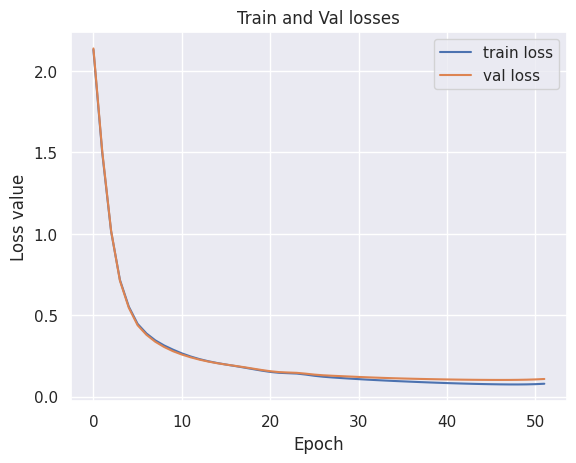

In [ ]:
sns.set()
train_loss = neural_network.train_epoch_losses
val_loss = neural_network.val_epoch_losses

plt.figure(figsize=(10,10))
fig, ax = plt.subplots()
line1, = ax.plot(np.arange(len(train_loss)), train_loss, label='train loss')
line2, = ax.plot(np.arange(len(val_loss)), val_loss, label='val loss')
ax.set_title('Train and Val losses')
ax.set_ylabel('Loss value')
ax.set_xlabel('Epoch')
ax.legend()

plt.show()

# Оценка на тестовом множестве

In [ ]:
preds = neural_network.predict(test_images)

## Значение ошибки кроссентропии на тестовом множестве

In [ ]:
neural_network.loss(neural_network.forward(test_images), test_labels)

tensor(0.1025, grad_fn=<NllLossBackward0>)

## Визуальная оценка качества работы нейронной сети

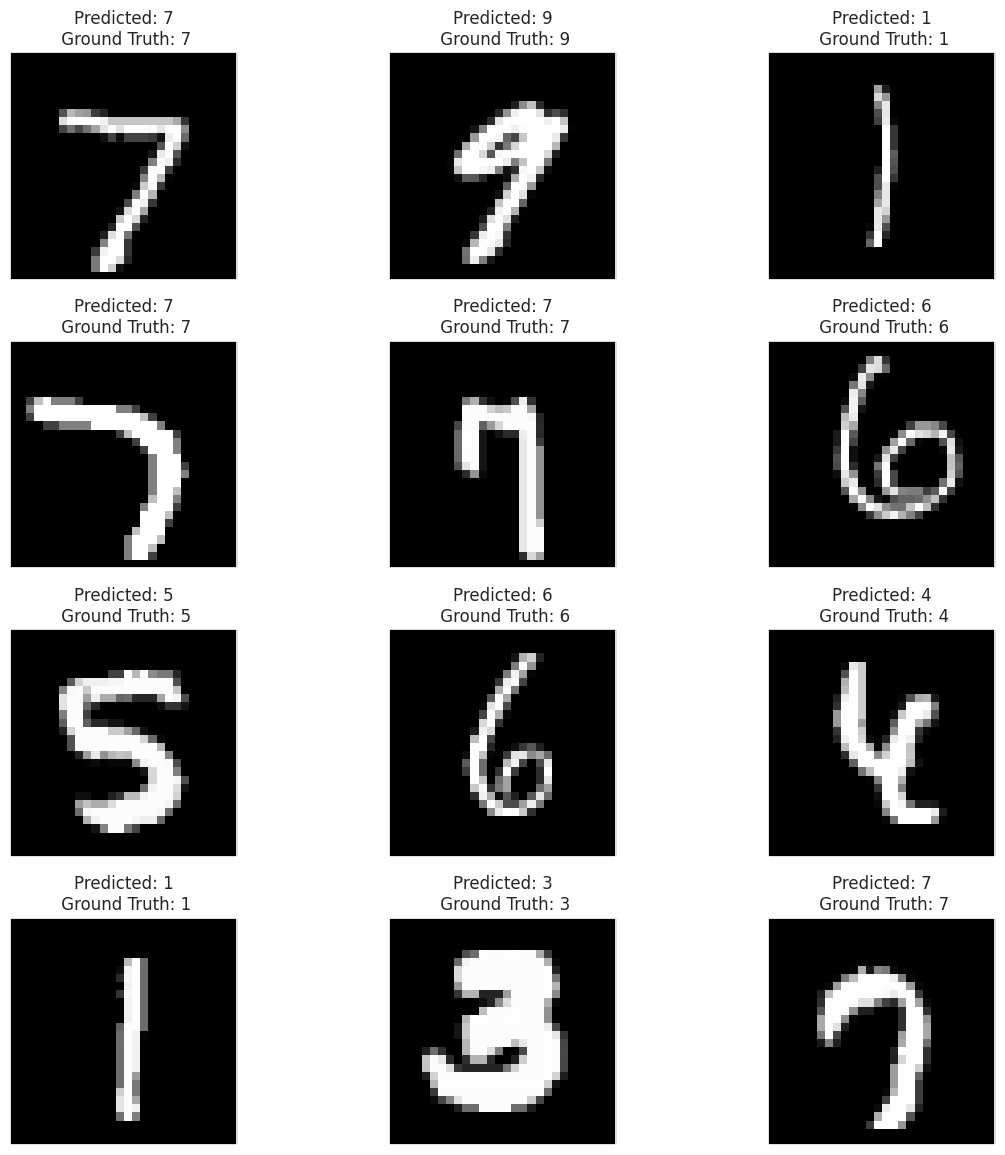

In [ ]:
fig = plt.figure(figsize=(12,12))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.tight_layout()
    plt.imshow(test_images[i * 20][0], cmap='gray', interpolation='none')
    plt.title("Predicted: {}\n Ground Truth: {}".format(preds[i * 20], test_labels[i * 20]))
    plt.xticks([])
    plt.yticks([])